In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from tqdm import tqdm

In [2]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

stg_color = '#20B2AA'
ifg_color = '#6A5ACD'
insula_color = '#D4AF37'


reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)
oranges = sns.light_palette(orange, as_cmap=True)
greens = sns.light_palette(green, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')

Using notebook 3d backend.


In [3]:
# Step 1. Get how many unique subjects across those four dataset

PHONEME_PATH = '/cwork/ns458/BIDS-1.4_Phoneme_sequencing/BIDS/'
TIMIT_PATH = '/cwork/ns458/BIDS-1.0_TIMIT/BIDS/'
SENTENCE_PATH = '/cwork/ns458/BIDS-1.4_SentenceRep/BIDS/'
LEXICAL_PATH = '/cwork/ns458/BIDS-1.0_LexicalDecRepDelay/BIDS/'

RECON_DIR = '/cwork/ns458/ECoG_Recon/'

def bids_to_recon_id(bids_subject: str) -> str:
    """Convert BIDS subject ID (e.g. 'D0088') to FreeSurfer/ECoG_Recon ID (e.g. 'D88')."""
    prefix = bids_subject[0]
    num = int(bids_subject[1:])
    return f"{prefix}{num}"

def get_subjects_with_parcellation(bids_root: str, ref: str = 'bipolar') -> list:
    """Get subjects that have parcellation CSV files."""
    parc_dir = Path(bids_root) / 'derivatives' / 'parcellation'
    if not parc_dir.exists():
        return []
    subjects = []
    for sub_dir in sorted(parc_dir.glob('sub-*')):
        csv_files = list((sub_dir / ref).glob('*.csv'))
        if csv_files:
            subjects.append(sub_dir.name.replace('sub-', ''))
    return subjects

# Collect subjects from all datasets
all_subjects = set()
dataset_subjects = {}

for name, path in [('Phoneme', PHONEME_PATH), ('TIMIT', TIMIT_PATH), 
                   ('Sentence', SENTENCE_PATH), ('Lexical', LEXICAL_PATH)]:
    subs = get_subjects_with_parcellation(path)
    dataset_subjects[name] = subs
    all_subjects.update(subs)
    print(f"{name}: {len(subs)} subjects with parcellation")

print(f"\\nTotal unique subjects: {len(all_subjects)}")
print(f"Subjects: {sorted(all_subjects)}")

Phoneme: 49 subjects with parcellation
TIMIT: 29 subjects with parcellation
Sentence: 32 subjects with parcellation
Lexical: 40 subjects with parcellation
\nTotal unique subjects: 73
Subjects: ['D0005', 'D0007', 'D0008', 'D0009', 'D0015', 'D0016', 'D0017', 'D0018', 'D0019', 'D0020', 'D0022', 'D0023', 'D0024', 'D0025', 'D0026', 'D0027', 'D0028', 'D0029', 'D0031', 'D0032', 'D0033', 'D0035', 'D0038', 'D0040', 'D0041', 'D0042', 'D0044', 'D0045', 'D0046', 'D0047', 'D0049', 'D0052', 'D0053', 'D0054', 'D0055', 'D0056', 'D0057', 'D0058', 'D0059', 'D0060', 'D0061', 'D0063', 'D0064', 'D0065', 'D0066', 'D0067', 'D0068', 'D0069', 'D0070', 'D0071', 'D0073', 'D0075', 'D0077', 'D0079', 'D0080', 'D0081', 'D0084', 'D0085', 'D0086', 'D0088', 'D0090', 'D0091', 'D0092', 'D0093', 'D0094', 'D0095', 'D0096', 'D0100', 'D0101', 'D0102', 'D0103', 'D0115', 'D0117']


In [4]:
# Step 2: Get the insula electrodes for a specific subject

def load_parcellation(bids_root: str, subject: str, ref: str = 'bipolar') -> pd.DataFrame:
    """Load parcellation CSV for a subject using BIDSPath."""
    bids_path = BIDSPath(
        root=os.path.join(bids_root, 'derivatives', 'parcellation'),
        subject=subject,
        suffix='aparc2009s',
        datatype=ref,
        processing='10mm',
        extension='.csv',
        check=False
    )
    csv_files = list(bids_path.match())
    if not csv_files:
        return None
    return pd.read_csv(csv_files[0])

def get_insula_electrodes(df: pd.DataFrame) -> pd.DataFrame:
    """Filter electrodes labeled as insula (INS) in the roi column."""
    return df[df['roi'] == 'INS'].copy()

# Test with one subject - pick one that has insula electrodes
TEST_SUBJECT = 'D0045'
TEST_BIDS_ROOT = PHONEME_PATH

df = load_parcellation(TEST_BIDS_ROOT, TEST_SUBJECT)
if df is not None:
    insula_df = get_insula_electrodes(df)
    print(f"Subject {TEST_SUBJECT}: {len(insula_df)} insula electrodes out of {len(df)} total")
    print(f"\\nInsula electrodes:")
    print(insula_df[['name', 'x', 'y', 'z', 'label', 'roi', 'hemi']])

Subject D0045: 11 insula electrodes out of 104 total
\nInsula electrodes:
             name       x       y       z                           label  \
0   D0045_RMST1-2  0.0365 -0.0150 -0.0045    ctx_rh_S_circular_insula_inf   
1   D0045_RMST2-3  0.0395 -0.0150 -0.0040    ctx_rh_S_circular_insula_inf   
22   D0045_RAI1-2  0.0380  0.0170 -0.0100          ctx_rh_G_insular_short   
23   D0045_RAI2-3  0.0380  0.0170 -0.0060          ctx_rh_G_insular_short   
24   D0045_RAI3-4  0.0380  0.0170 -0.0020          ctx_rh_G_insular_short   
25   D0045_RAI4-5  0.0380  0.0170  0.0020          ctx_rh_G_insular_short   
37   D0045_RPI1-2  0.0360  0.0000 -0.0080    ctx_rh_S_circular_insula_inf   
38   D0045_RPI2-3  0.0360 -0.0005 -0.0040  ctx_rh_G_Ins_lg_and_S_cent_ins   
39   D0045_RPI3-4  0.0360 -0.0010  0.0005  ctx_rh_G_Ins_lg_and_S_cent_ins   
41   D0045_RPI5-6  0.0365 -0.0015  0.0080          ctx_rh_G_insular_short   
42   D0045_RPI6-7  0.0370 -0.0020  0.0135    ctx_rh_S_circular_insula_sup   

 

In [5]:
# Helper function for subject directory
def get_subject_dir(bids_subject: str, recon_dir: str = RECON_DIR) -> str:
    """Get FreeSurfer subject directory path."""
    recon_id = bids_to_recon_id(bids_subject)
    return os.path.join(recon_dir, recon_id)

In [6]:
# Step 4: Batch find all subjects with insula electrodes

def find_subjects_with_insula(bids_roots: list, ref: str = 'bipolar') -> dict:
    """Find all subjects that have insula electrodes across datasets."""
    results = {}
    for bids_root in bids_roots:
        parc_dir = Path(bids_root) / 'derivatives' / 'parcellation'
        if not parc_dir.exists():
            continue
        for sub_dir in sorted(parc_dir.glob('sub-*')):
            subject = sub_dir.name.replace('sub-', '')
            df_temp = load_parcellation(bids_root, subject, ref)
            if df_temp is not None and 'roi' in df_temp.columns:
                insula_df_temp = get_insula_electrodes(df_temp)
                if len(insula_df_temp) > 0:
                    if subject not in results:
                        results[subject] = {
                            'bids_root': bids_root,
                            'n_insula': len(insula_df_temp),
                            'n_total': len(df_temp),
                        }
    return results

# Find all subjects with insula electrodes
bids_roots = [PHONEME_PATH, TIMIT_PATH, SENTENCE_PATH, LEXICAL_PATH]
subjects_with_insula = find_subjects_with_insula(bids_roots)

print(f"Found {len(subjects_with_insula)} subjects with insula electrodes:")
print("-" * 50)
for sub, info in sorted(subjects_with_insula.items()):
    recon_id = bids_to_recon_id(sub)
    recon_exists = os.path.exists(os.path.join(RECON_DIR, recon_id))
    status = "✓" if recon_exists else "✗ (no recon)"
    print(f"  {sub} -> {recon_id}: {info['n_insula']:3d} insula / {info['n_total']:3d} total {status}")

Found 49 subjects with insula electrodes:
--------------------------------------------------
  D0007 -> D7:   4 insula /  89 total ✓
  D0022 -> D22:   2 insula /  83 total ✓
  D0023 -> D23:   2 insula / 109 total ✓
  D0027 -> D27:   2 insula /  88 total ✓
  D0028 -> D28:   5 insula /  70 total ✓
  D0032 -> D32:   5 insula / 108 total ✓
  D0033 -> D33:   6 insula / 222 total ✓
  D0035 -> D35:   4 insula / 112 total ✓
  D0038 -> D38:   2 insula / 111 total ✓
  D0040 -> D40:  13 insula / 174 total ✓
  D0041 -> D41:   1 insula / 232 total ✓
  D0042 -> D42:   4 insula / 144 total ✓
  D0044 -> D44:   8 insula / 160 total ✓
  D0045 -> D45:  11 insula / 104 total ✓
  D0046 -> D46:   2 insula / 145 total ✓
  D0047 -> D47:   4 insula /  47 total ✓
  D0049 -> D49:   8 insula / 177 total ✓
  D0052 -> D52:   4 insula / 136 total ✓
  D0053 -> D53:   4 insula / 132 total ✓
  D0055 -> D55:   7 insula /  94 total ✓
  D0057 -> D57:   1 insula / 133 total ✓
  D0058 -> D58:   5 insula / 226 total ✓
  D005

Subject: D0045
FreeSurfer dir: /cwork/ns458/ECoG_Recon/D45
Reading labels from parcellation...


   read 75 labels from /cwork/ns458/ECoG_Recon/D45/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/D45/label/rh.aparc.a2009s.annot


2025-12-25 18:41:00.062 (   4.471s) [    7EFED9451440]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:41:00.097 (   4.506s) [    7EFED9451440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x7a514f0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:41:00.180 (   4.589s) [    7EFED9451440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x7b69540): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D en

Insula-labeled electrodes to verify:
------------------------------------------------------------
  D0045_RMST1-2        | ctx_rh_S_circular_insula_inf            
  D0045_RMST2-3        | ctx_rh_S_circular_insula_inf            
  D0045_RAI1-2         | ctx_rh_G_insular_short                  
  D0045_RAI2-3         | ctx_rh_G_insular_short                  
  D0045_RAI3-4         | ctx_rh_G_insular_short                  
  D0045_RAI4-5         | ctx_rh_G_insular_short                  
  D0045_RPI1-2         | ctx_rh_S_circular_insula_inf            
  D0045_RPI2-3         | ctx_rh_G_Ins_lg_and_S_cent_ins          
  D0045_RPI3-4         | ctx_rh_G_Ins_lg_and_S_cent_ins          
  D0045_RPI5-6         | ctx_rh_G_insular_short                  
  D0045_RPI6-7         | ctx_rh_S_circular_insula_sup            


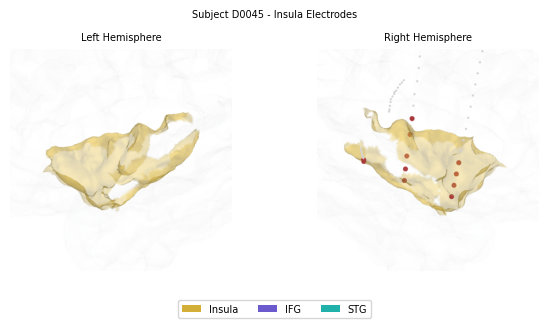

In [7]:
# Step 3: Focused view on insula electrodes with ROI labels highlighted
# Reference: insula_temporal.ipynb Cell 17

import pyvista as pv
from scipy.spatial import cKDTree
from mne.viz import Brain

# Define label patterns for each ROI
insula_patterns = ['G_insular_short', 'G_Ins_lg_and_S_cent_ins',
                   'S_circular_insula_ant', 'S_circular_insula_inf', 'S_circular_insula_sup']
ifg_patterns = ['G_front_inf-Opercular', 'G_front_inf-Orbital', 'G_front_inf-Triangul']
stg_patterns = ['G_temp_sup-Lateral', 'G_temp_sup-Plan_polar', 'G_temp_sup-Plan_tempo', 'G_temporal_transverse']

def get_insula_center_from_labels(labels, hemi, pial_coords):
    """Calculate the center of insula region from labels."""
    vertices = []
    for lab in labels:
        if lab.hemi == hemi and any(p in lab.name for p in insula_patterns):
            vertices.extend(lab.vertices)
    if vertices:
        insula_coords = pial_coords[vertices]
        return insula_coords.mean(axis=0)
    return None

def plot_insula_focused(
    bids_subject: str,
    df: pd.DataFrame,
    recon_dir: str = RECON_DIR,
    show_all_electrodes: bool = True,
):
    """
    Plot brain with focus on insula region, centered on insula.
    Highlights INS, IFG, STG with different colors using label objects.
    """
    subject_id = bids_to_recon_id(bids_subject)
    subjects_dir = recon_dir
    
    insula_df = get_insula_electrodes(df)
    non_insula_df = df[df['roi'] != 'INS'] if 'roi' in df.columns else df
    
    # Read labels from annotation - use surf_name='pial' since white surface may not exist
    labels = mne.read_labels_from_annot(
        subject=subject_id, parc='aparc.a2009s',
        hemi='both', subjects_dir=subjects_dir,
        surf_name='pial'
    )
    
    # Load pial surfaces for insula center calculation
    lh_pial_coords, _ = mne.read_surface(f"{subjects_dir}/{subject_id}/surf/lh.pial")
    rh_pial_coords, _ = mne.read_surface(f"{subjects_dir}/{subject_id}/surf/rh.pial")
    
    # Get insula centers
    lh_insula_center = get_insula_center_from_labels(labels, 'lh', lh_pial_coords)
    rh_insula_center = get_insula_center_from_labels(labels, 'rh', rh_pial_coords)
    
    # Create brain objects
    lh_brain = Brain(
        subject_id, subjects_dir=subjects_dir, surf="pial",
        hemi="lh", background="white", show=False,
        cortex=(0.9, 0.9, 0.9), alpha=0.01, size=(800, 800)
    )
    rh_brain = Brain(
        subject_id, subjects_dir=subjects_dir, surf="pial",
        hemi="rh", background="white", show=False,
        cortex=(0.9, 0.9, 0.9), alpha=0.01, size=(800, 800)
    )
    
    # Add labels with different colors for each ROI (using label objects directly)
    for lab in labels:
        # Insula
        if any(pattern in lab.name for pattern in insula_patterns):
            if lab.hemi == 'lh':
                lh_brain.add_label(lab, borders=False, color=insula_color, alpha=0.6)
            elif lab.hemi == 'rh':
                rh_brain.add_label(lab, borders=False, color=insula_color, alpha=0.6)
        # IFG
        elif any(pattern in lab.name for pattern in ifg_patterns):
            if lab.hemi == 'lh':
                lh_brain.add_label(lab, borders=False, color=ifg_color, alpha=0.02)
            elif lab.hemi == 'rh':
                rh_brain.add_label(lab, borders=False, color=ifg_color, alpha=0.02)
        # STG
        elif any(pattern in lab.name for pattern in stg_patterns):
            if lab.hemi == 'lh':
                lh_brain.add_label(lab, borders=False, color=stg_color, alpha=0.02)
            elif lab.hemi == 'rh':
                rh_brain.add_label(lab, borders=False, color=stg_color, alpha=0.02)
    
    # Add electrodes function
    def add_electrodes_to_brain(brain, elec_df, color, point_size=15):
        if len(elec_df) == 0:
            return
        coords = elec_df[['x', 'y', 'z']].values.copy()
        if len(coords) > 0 and np.max(np.abs(coords)) < 1:
            coords = coords * 1000
        for coord in coords:
            cloud = pv.PolyData(coord.reshape(1, 3))
            brain._renderer.plotter.add_mesh(
                cloud,
                render_points_as_spheres=True,
                point_size=point_size,
                color=color,
                lighting=False,
            )
    
    # Split electrodes by hemisphere
    lh_insula = insula_df[insula_df['x'] < 0] if len(insula_df) > 0 else pd.DataFrame()
    rh_insula = insula_df[insula_df['x'] > 0] if len(insula_df) > 0 else pd.DataFrame()
    
    if show_all_electrodes:
        lh_non = non_insula_df[non_insula_df['x'] < 0] if len(non_insula_df) > 0 else pd.DataFrame()
        rh_non = non_insula_df[non_insula_df['x'] > 0] if len(non_insula_df) > 0 else pd.DataFrame()
        add_electrodes_to_brain(lh_brain, lh_non, 'lightgray', point_size=8)
        add_electrodes_to_brain(rh_brain, rh_non, 'lightgray', point_size=8)
    
    add_electrodes_to_brain(lh_brain, lh_insula, red, point_size=18)
    add_electrodes_to_brain(rh_brain, rh_insula, red, point_size=18)
    
    # Set view centered on insula
    if lh_insula_center is not None:
        lh_brain.show_view(azimuth=180, elevation=90, distance=180, focalpoint=lh_insula_center)
    else:
        lh_brain.show_view(azimuth=180, elevation=90, distance=200)
    
    if rh_insula_center is not None:
        rh_brain.show_view(azimuth=0, elevation=90, distance=180, focalpoint=rh_insula_center)
    else:
        rh_brain.show_view(azimuth=0, elevation=90, distance=200)
    
    # Print electrode info
    print("Insula-labeled electrodes to verify:")
    print("-" * 60)
    for _, row in insula_df.iterrows():
        print(f"  {row['name']:20s} | {row['label']:40s}")
    
    return lh_brain, rh_brain

# Visualize test subject
subject_dir = get_subject_dir(TEST_SUBJECT)
print(f"Subject: {TEST_SUBJECT}")
print(f"FreeSurfer dir: {subject_dir}")

if df is not None and os.path.exists(subject_dir):
    lh_brain, rh_brain = plot_insula_focused(TEST_SUBJECT, df)
    
    # Screenshot and display
    fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
    
    axes[0].imshow(lh_brain.screenshot(mode="rgb"))
    axes[0].axis("off")
    axes[0].set_title("Left Hemisphere", fontsize=fontsize)
    
    axes[1].imshow(rh_brain.screenshot(mode="rgb"))
    axes[1].axis("off")
    axes[1].set_title("Right Hemisphere", fontsize=fontsize)
    
    lh_brain.close()
    rh_brain.close()
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=insula_color, label='Insula'),
        Patch(facecolor=ifg_color, label='IFG'),
        Patch(facecolor=stg_color, label='STG'),
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=fontsize)
    
    plt.suptitle(f"Subject {TEST_SUBJECT} - Insula Electrodes", fontsize=fontsize)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

In [8]:
# Step 4: Export 3D interactive HTML visualization
# This creates an interactive HTML file that can be opened in a browser

import pyvista as pv

def export_insula_3d_html(
    bids_subject: str,
    df: pd.DataFrame,
    output_dir: str = '/hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html',
    recon_dir: str = RECON_DIR,
):
    """
    Export 3D interactive visualization of insula electrodes to HTML.
    """
    subject_id = bids_to_recon_id(bids_subject)
    subjects_dir = recon_dir
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    insula_df = get_insula_electrodes(df)
    non_insula_df = df[df['roi'] != 'INS'] if 'roi' in df.columns else df
    
    # Read labels from annotation
    labels = mne.read_labels_from_annot(
        subject=subject_id, parc='aparc.a2009s',
        hemi='both', subjects_dir=subjects_dir,
        surf_name='pial'
    )
    
    # Load pial surfaces
    lh_pial_coords, lh_faces = mne.read_surface(f"{subjects_dir}/{subject_id}/surf/lh.pial")
    rh_pial_coords, rh_faces = mne.read_surface(f"{subjects_dir}/{subject_id}/surf/rh.pial")
    
    # Get insula labels vertices
    lh_insula_vertices = set()
    rh_insula_vertices = set()
    lh_ifg_vertices = set()
    rh_ifg_vertices = set()
    lh_stg_vertices = set()
    rh_stg_vertices = set()
    
    for lab in labels:
        if any(p in lab.name for p in insula_patterns):
            if lab.hemi == 'lh':
                lh_insula_vertices.update(lab.vertices)
            else:
                rh_insula_vertices.update(lab.vertices)
        elif any(p in lab.name for p in ifg_patterns):
            if lab.hemi == 'lh':
                lh_ifg_vertices.update(lab.vertices)
            else:
                rh_ifg_vertices.update(lab.vertices)
        elif any(p in lab.name for p in stg_patterns):
            if lab.hemi == 'lh':
                lh_stg_vertices.update(lab.vertices)
            else:
                rh_stg_vertices.update(lab.vertices)
    
    # Create PyVista plotter
    plotter = pv.Plotter(off_screen=True)
    plotter.set_background('white')
    
    # Helper function to create mesh from FreeSurfer surface
    def create_pv_mesh(coords, faces):
        # FreeSurfer faces are 0-indexed triangles
        # PyVista needs faces in format [3, v0, v1, v2, 3, v0, v1, v2, ...]
        n_faces = len(faces)
        pv_faces = np.zeros((n_faces, 4), dtype=int)
        pv_faces[:, 0] = 3
        pv_faces[:, 1:] = faces
        return pv.PolyData(coords, pv_faces.flatten())
    
    # Create brain meshes
    lh_mesh = create_pv_mesh(lh_pial_coords, lh_faces)
    rh_mesh = create_pv_mesh(rh_pial_coords, rh_faces)
    
    # Create vertex colors for left hemisphere
    lh_colors = np.ones((len(lh_pial_coords), 4)) * [0.9, 0.9, 0.9, 0.01]  # Default: gray, transparent
    for v in lh_insula_vertices:
        if v < len(lh_colors):
            lh_colors[v] = [0.83, 0.69, 0.22, 0.8]  # Insula: gold
    for v in lh_ifg_vertices:
        if v < len(lh_colors):
            lh_colors[v] = [0.42, 0.35, 0.80, 0.1]  # IFG: purple
    for v in lh_stg_vertices:
        if v < len(lh_colors):
            lh_colors[v] = [0.13, 0.70, 0.67, 0.1]  # STG: teal
    
    # Create vertex colors for right hemisphere
    rh_colors = np.ones((len(rh_pial_coords), 4)) * [0.9, 0.9, 0.9, 0.01]
    for v in rh_insula_vertices:
        if v < len(rh_colors):
            rh_colors[v] = [0.83, 0.69, 0.22, 0.8]
    for v in rh_ifg_vertices:
        if v < len(rh_colors):
            rh_colors[v] = [0.42, 0.35, 0.80, 0.1]
    for v in rh_stg_vertices:
        if v < len(rh_colors):
            rh_colors[v] = [0.13, 0.70, 0.67, 0.1]
    
    # Add meshes with vertex colors
    lh_mesh['colors'] = (lh_colors[:, :3] * 255).astype(np.uint8)
    rh_mesh['colors'] = (rh_colors[:, :3] * 255).astype(np.uint8)
    
    plotter.add_mesh(lh_mesh, scalars='colors', rgb=True, opacity=0.2, smooth_shading=True)
    plotter.add_mesh(rh_mesh, scalars='colors', rgb=True, opacity=0.2, smooth_shading=True)
    
    # Add electrodes
    def add_electrodes(elec_df, color, size=5, label_prefix=''):
        if len(elec_df) == 0:
            return
        
        coords = elec_df[['x', 'y', 'z']].values.copy()
        if len(coords) > 0 and np.max(np.abs(coords)) < 1:
            coords = coords * 1000
        
        # Add electrode points
        plotter.add_points(coords, color=color, point_size=size, render_points_as_spheres=True)
        
        # Add electrode labels
        for i, (idx, row) in enumerate(elec_df.iterrows()):
            plotter.add_point_labels(
                coords[i:i+1], 
                [row['name']], 
                point_size=size*2, 
                text_color='black', 
                font_size=10,
                shape_color=color,
                opacity=0.8
            )
    
    # Add non-insula electrodes (gray, smaller)
    add_electrodes(non_insula_df, 'lightgray', size=0.5)
    
    # Add insula electrodes (red, larger)
    add_electrodes(insula_df, red, size=1)
    
    # Set camera to focus on insula region
    # Calculate insula center for camera focus
    if len(lh_insula_vertices) > 0:
        lh_center = lh_pial_coords[list(lh_insula_vertices)].mean(axis=0)
        plotter.camera.focal_point = lh_center
        plotter.camera.position = [lh_center[0] - 150, lh_center[1], lh_center[2]]
    
    # Export to HTML
    output_path = os.path.join(output_dir, f'{bids_subject}_insula_3d.html')
    plotter.export_html(output_path)
    plotter.close()
    
    print(f"Exported 3D HTML to: {output_path}")
    print(f"Open this file in a web browser to interact with the 3D visualization.")
    
    # Also print electrode info
    print("\nInsula-labeled electrodes:")
    print("-" * 70)
    for _, row in insula_df.iterrows():
        print(f"  {row['name']:20s} | {row['label']:40s} | frac={row.get('fraction', 'N/A')}")
    
    return output_path

# Export for test subject
print(f"Exporting 3D HTML for subject {TEST_SUBJECT}...")
html_path = export_insula_3d_html(TEST_SUBJECT, df)
print(f"\nDone! You can download and open the HTML file in your browser.")

Exporting 3D HTML for subject D0045...
Reading labels from parcellation...


   read 75 labels from /cwork/ns458/ECoG_Recon/D45/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/D45/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:41:04.780 (   9.189s) [    7EFED9451440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x6ac5740): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:41:04.880 (   9.289s) [    7EFED9451440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x6ac5740): EGL device index: 0 could not be initialized. Trying other devices...


TypeError: BasePlotter.add_point_labels() got an unexpected keyword argument 'opacity'

In [ ]:
# Step 5: Generate HTML visualizations for ALL subjects with insula electrodes
# This will create an interactive 3D HTML file for each subject

def generate_all_subject_htmls(subjects_dict: dict, output_dir: str = '/hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all'):
    """
    Generate 3D HTML visualizations for all subjects with insula electrodes.
    
    Parameters:
    -----------
    subjects_dict : dict
        Dictionary with subject info from find_subjects_with_insula()
    output_dir : str
        Directory to save all HTML files
    """
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Generating HTML files for {len(subjects_dict)} subjects...")
    print("=" * 80)
    
    successful = []
    failed = []
    
    for i, (subject, info) in enumerate(sorted(subjects_dict.items())):
        print(f"\n[{i+1}/{len(subjects_dict)}] Processing {subject}...")
        
        try:
            # Load parcellation data
            df = load_parcellation(info['bids_root'], subject)
            
            if df is None:
                print(f"  ❌ Failed to load parcellation for {subject}")
                failed.append(subject)
                continue
            
            # Check if subject has reconstruction
            subject_dir = get_subject_dir(subject)
            if not os.path.exists(subject_dir):
                print(f"  ❌ No reconstruction directory for {subject}")
                failed.append(subject)
                continue
            
            # Generate HTML
            html_path = export_insula_3d_html(
                subject, 
                df, 
                output_dir=output_dir
            )
            
            successful.append(subject)
            print(f"  ✅ Generated: {html_path}")
            
        except Exception as e:
            print(f"  ❌ Error processing {subject}: {str(e)}")
            failed.append(subject)
    
    # Summary
    print("\n" + "=" * 80)
    print("GENERATION SUMMARY:")
    print(f"  ✅ Successful: {len(successful)} subjects")
    print(f"  ❌ Failed: {len(failed)} subjects")
    
    if successful:
        print(f"\nSuccessful subjects: {', '.join(successful)}")
    if failed:
        print(f"\nFailed subjects: {', '.join(failed)}")
    
    print(f"\nAll HTML files saved to: {output_dir}")
    print("You can download these files and open them in a web browser.")
    
    return successful, failed

# Execute the batch generation
successful_subjects, failed_subjects = generate_all_subject_htmls(subjects_with_insula)

# Create a summary HTML index file
def create_index_html(subjects_dict: dict, output_dir: str):
    """Create an index HTML file with links to all subject visualizations."""
    
    index_path = os.path.join(output_dir, 'index.html')
    
    html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Insula Electrode Visualizations - All Subjects</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; }}
        h1 {{ color: #333; }}
        .subject-grid {{ display: grid; grid-template-columns: repeat(auto-fill, minmax(300px, 1fr)); gap: 20px; }}
        .subject-card {{ border: 1px solid #ddd; padding: 15px; border-radius: 8px; }}
        .subject-card h3 {{ margin: 0 0 10px 0; color: #2c5aa0; }}
        .info {{ font-size: 0.9em; color: #666; margin: 5px 0; }}
        .link {{ display: inline-block; margin-top: 10px; padding: 8px 16px; background: #2c5aa0; color: white; text-decoration: none; border-radius: 4px; }}
        .link:hover {{ background: #1e3f73; }}
    </style>
</head>
<body>
    <h1>Insula Electrode Visualizations - All Subjects</h1>
    <p>Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
    <p>Total subjects with insula electrodes: {len(subjects_dict)}</p>
    
    <div class="subject-grid">
"""
    
    for subject, info in sorted(subjects_dict.items()):
        html_content += f"""
        <div class="subject-card">
            <h3>{subject}</h3>
            <div class="info">Insula electrodes: {info['n_insula']}</div>
            <div class="info">Total electrodes: {info['n_total']}</div>
            <div class="info">FreeSurfer ID: {bids_to_recon_id(subject)}</div>
            <a href="{subject}_insula_3d.html" class="link">View 3D Visualization</a>
        </div>
"""
    
    html_content += """
    </div>
</body>
</html>
"""
    
    with open(index_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created index HTML: {index_path}")
    return index_path

# Create index file
index_path = create_index_html(subjects_with_insula, '/hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all')

print(f"\n🎉 All done! You can find all visualizations in the output directory.")
print(f"📁 Directory: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all")
print(f"📄 Index file: {index_path}")

Generating HTML files for 49 subjects...

[1/49] Processing D0007...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D7/label/lh.aparc.a2009s.annot


   read 73 labels from /cwork/ns458/ECoG_Recon/D7/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:14.449 ( 229.069s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0xc5a8090): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:14.512 ( 229.132s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0xc5a8090): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0007_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0007_RFG1-2         | ctx_rh_G_insular_short                   | frac=0.0921084192852002
  D0007_RFG3-4         | ctx_rh_S_circular_insula_inf             | frac=0.0760374190453346
  D0007_RFG10-11       | ctx_rh_S_circular_insula_sup             | frac=0.0676421204125689
  D0007_RFG11-12       | ctx_rh_S_circular_insula_inf             | frac=0.0590069561045814
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0007_insula_3d.html

[2/49] Processing D0022...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D22/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:19.735 ( 234.355s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0xc5a8090): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:19.801 ( 234.421s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0xc5a8090): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0022_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0022_LPIF3-4        | ctx_lh_S_circular_insula_inf             | frac=0.1655073159030942
  D0022_LPIF4-5        | ctx_lh_S_circular_insula_inf             | frac=0.1947709282801631
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0022_insula_3d.html

[3/49] Processing D0023...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D23/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/D23/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:25.297 ( 239.917s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0xc5a8090): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:25.359 ( 239.979s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0xc5a8090): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0023_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0023_R2IF1-2        | ctx_rh_S_circular_insula_sup             | frac=0.1228112257136003
  D0023_R2IF2-3        | ctx_rh_S_circular_insula_sup             | frac=0.1400815543295754
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0023_insula_3d.html

[4/49] Processing D0027...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D27/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/D27/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:33.215 ( 247.834s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x21cd39f0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:33.286 ( 247.906s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x21cd39f0): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0027_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0027_LAI2-3         | ctx_lh_S_circular_insula_sup             | frac=0.1806188534420724
  D0027_LAI3-4         | ctx_lh_S_circular_insula_sup             | frac=0.164068121851763
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0027_insula_3d.html

[5/49] Processing D0028...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D28/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/D28/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:38.921 ( 253.541s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1397edb0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:38.995 ( 253.615s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1397edb0): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0028_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0028_LAI1-2         | ctx_lh_G_insular_short                   | frac=0.3015111537538978
  D0028_LAI3-4         | ctx_lh_G_insular_short                   | frac=0.2456224514272007
  D0028_LPI1-2         | ctx_lh_G_Ins_lg_and_S_cent_ins           | frac=0.1575917486207723
  D0028_LPI2-3         | ctx_lh_G_Ins_lg_and_S_cent_ins           | frac=0.1763012712880786
  D0028_LPI3-4         | ctx_lh_S_circular_insula_sup             | frac=0.179419525065963
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0028_insula_3d.html

[6/49] Processing D0032...
Reading labels from parcellation...
   read 75 labels from /

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:44.302 ( 258.922s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8ba6840): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:44.374 ( 258.994s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8ba6840): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0032_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0032_LAI1-2         | ctx_lh_G_insular_short                   | frac=0.2792036459582633
  D0032_LAI3-4         | ctx_lh_G_insular_short                   | frac=0.2768049892060446
  D0032_LAI4-5         | ctx_lh_S_circular_insula_sup             | frac=0.1348045094746941
  D0032_LPI6-7         | ctx_lh_S_circular_insula_sup             | frac=0.1252098824658191
  D0032_LPI7-8         | ctx_lh_S_circular_insula_sup             | frac=0.129287598944591
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0032_insula_3d.html

[7/49] Processing D0033...
Reading labels from parcellation...
   read 75 labels from /

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:50.761 ( 265.381s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x139782a0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:37:50.831 ( 265.451s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x139782a0): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0033_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0033_LI1-3          | ctx_lh_S_circular_insula_inf             | frac=0.198848644758935
  D0033_LI5-7          | ctx_lh_G_Ins_lg_and_S_cent_ins           | frac=0.1616694650995442
  D0033_LI7-9          | ctx_lh_G_insular_short                   | frac=0.0777164787718877
  D0033_RI1-3          | ctx_rh_G_Ins_lg_and_S_cent_ins           | frac=0.2552170784360758
  D0033_RI3-5          | ctx_rh_G_Ins_lg_and_S_cent_ins           | frac=0.2130007195970256
  D0033_RI5-7          | ctx_rh_G_insular_short                   | frac=0.0736387622931158
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0033_insula_3d.h

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:02.286 ( 276.905s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x125f6ba0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:02.369 ( 276.989s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x125f6ba0): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0035_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0035_LAI1-2         | ctx_lh_G_insular_short                   | frac=0.3031902134804509
  D0035_LAI2-3         | ctx_lh_G_insular_short                   | frac=0.2758455265051571
  D0035_LPI5-6         | ctx_lh_G_Ins_lg_and_S_cent_ins           | frac=0.135044375149916
  D0035_LPI6-7         | ctx_lh_S_circular_insula_sup             | frac=0.1556728232189973
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0035_insula_3d.html

[9/49] Processing D0038...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D38/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/E

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:09.748 ( 284.368s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x125f6ba0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:09.844 ( 284.464s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x125f6ba0): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0038_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0038_RI2-3          | ctx_rh_G_insular_short                   | frac=0.1280882705684816
  D0038_RI3-4          | ctx_rh_S_circular_insula_sup             | frac=0.2082034060925881
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0038_insula_3d.html

[10/49] Processing D0040...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D40/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/D40/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:16.820 ( 291.440s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:16.894 ( 291.514s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0040_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0040_L1IF2-3        | ctx_lh_S_circular_insula_sup             | frac=0.1441592708083473
  D0040_L1IF3-4        | ctx_lh_S_circular_insula_ant             | frac=0.1472775245862317
  D0040_L2IF4-5        | ctx_lh_S_circular_insula_sup             | frac=0.156392420244663
  D0040_L2IF5-6        | ctx_lh_S_circular_insula_sup             | frac=0.1475173902614535
  D0040_L1SF1-2        | ctx_lh_S_circular_insula_sup             | frac=0.1604701367234348
  D0040_L1SF2-3        | ctx_lh_S_circular_insula_sup             | frac=0.1899736147757255
  D0040_L1SF3-4        | ctx_lh_S_circular_insula_sup             | frac=0.201247301511153

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:26.282 ( 300.902s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:26.374 ( 300.994s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0041_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0041_LAMT6-7        | ctx_lh_S_circular_insula_inf             | frac=0.100263852242744
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0041_insula_3d.html

[12/49] Processing D0042...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D42/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/D42/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:38.476 ( 313.096s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:38.551 ( 313.171s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0042_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0042_RAI3-4         | ctx_rh_G_Ins_lg_and_S_cent_ins           | frac=0.0551691053010314
  D0042_RAI6-7         | ctx_rh_S_circular_insula_sup             | frac=0.1727032861597505
  D0042_RAI7-8         | ctx_rh_S_circular_insula_sup             | frac=0.2249940033581194
  D0042_RAI8-9         | ctx_rh_S_circular_insula_sup             | frac=0.2223554809306788
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0042_insula_3d.html

[13/49] Processing D0044...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D44/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:46.649 ( 321.269s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:46.729 ( 321.349s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0044_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0044_LI4-5          | ctx_lh_S_circular_insula_inf             | frac=0.1918925401775006
  D0044_LI5-6          | ctx_lh_S_circular_insula_inf             | frac=0.2173183017510194
  D0044_LI6-7          | ctx_lh_S_circular_insula_inf             | frac=0.1779803310146318
  D0044_LI8-9          | ctx_lh_S_circular_insula_sup             | frac=0.1304869273207004
  D0044_RI1-2          | ctx_rh_S_circular_insula_inf             | frac=0.1981290477332693
  D0044_RI2-3          | ctx_rh_S_circular_insula_inf             | frac=0.19692971935716
  D0044_RI3-4          | ctx_rh_S_circular_insula_inf             | frac=0.1575917486207723

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:55.320 ( 329.940s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:38:55.392 ( 330.011s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0045_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0045_RMST1-2        | ctx_rh_S_circular_insula_inf             | frac=0.156392420244663
  D0045_RMST2-3        | ctx_rh_S_circular_insula_inf             | frac=0.1635883905013192
  D0045_RAI1-2         | ctx_rh_G_insular_short                   | frac=0.2389062125209882
  D0045_RAI2-3         | ctx_rh_G_insular_short                   | frac=0.2991124970016791
  D0045_RAI3-4         | ctx_rh_G_insular_short                   | frac=0.2988726313264572
  D0045_RAI4-5         | ctx_rh_G_insular_short                   | frac=0.2369872871192132
  D0045_RPI1-2         | ctx_rh_S_circular_insula_inf             | frac=0.162628927800431

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:39:01.925 ( 336.545s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:39:02.016 ( 336.636s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd272b9d490>

Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0046_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0046_L4ST1-2        | ctx_lh_S_circular_insula_inf             | frac=0.0985847925161909
  D0046_L4ST2-3        | ctx_lh_S_circular_insula_inf             | frac=0.1065003597985128
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0046_insula_3d.html

[16/49] Processing D0047...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D47/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/D47/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:39:10.197 ( 344.817s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:39:10.269 ( 344.889s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...


Exported 3D HTML with hover tooltips to: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0047_insula_3d.html
Open this file in a web browser to interact with the 3D visualization.
Hover over red insula electrodes to see their names and information.

Insula-labeled electrodes:
----------------------------------------------------------------------
  D0047_LI4-5          | ctx_lh_G_insular_short                   | frac=0.1719836891340849
  D0047_LI5-6          | ctx_lh_S_circular_insula_sup             | frac=0.1806188534420724
  D0047_LI6-7          | ctx_lh_S_circular_insula_sup             | frac=0.2098824658191412
  D0047_LI7-8          | ctx_lh_S_circular_insula_sup             | frac=0.1947709282801631
  ✅ Generated: /hpc/home/ns458/coganlab/nanlinshi/insula/viz/3d_html_all/D0047_insula_3d.html

[17/49] Processing D0049...
Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/D49/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:39:16.147 ( 350.767s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 18:39:16.224 ( 350.844s) [    7FD27597C440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x8125a50): EGL device index: 0 could not be initialized. Trying other devices...
